In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import os
from torch.linalg import vector_norm
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

In [ ]:
from RegressionL2_Sim_sparse import *
from DSR_Sim_sparse import *

In [ ]:
### Generate data

# Default parameter vector 'a' if not provided
    # a: 64-dimensional:
    # a[0] = 1.0
    # a[30], a[58] are non-zero
    # all others 0.0

a_true = torch.zeros(64, dtype=torch.float32)
nonzero_indices = [0, 30, 58]
for idx, val in zip(nonzero_indices, [1.0, 1.2, 1.5]):
    a_true[idx] = val


def preanm_simulator_64d(true_function, n, x_lower, x_upper, noise_std,
                         noise_dist, train, device=torch.device("cpu"),
                         a=a_true, noise_corr=0):
    """Data simulator for a pre-additive noise model (pre-ANM) with 64-dimensional covariates.

    Args:
        true_function (str or callable, optional): the true function g*. Defaults to "softplus".
            Choices: ["softplus", "square", "log", "cubic"] or a callable.
        n (int, optional): sample size. Defaults to 10000.
        x_lower (float, optional): lower bound of the training support. Defaults to 0.
        x_upper (float, optional): upper bound of the training support. Defaults to 2.
        noise_std (float, optional): standard deviation of the noise. Defaults to 1.
        noise_dist (str, optional): noise distribution. "gaussian" or "uniform". Defaults to "gaussian".
        train (bool, optional): if True, generates data for training. If False, generates evaluation data.
        device (str or torch.device, optional): device to place tensors. Defaults to CPU.
        a (torch.Tensor, optional): a 64-dim vector for the linear transformation.
            If None, the vector is constructed as follows:
            a[0] = 1.0
            a[2], a[30], a[58] = some non-zero values
            all other elements = 0.0
        noise_corr (float, optional): length-scale parameter for the squared exponential kernel.
            If noise_corr=0, no correlation between pixels.

    Returns:
        For train=True:
            x (torch.Tensor): shape (n,64), input data
            y (torch.Tensor): shape (n,1), output data
        For train=False:
            x_eval (torch.Tensor): shape (n,64), evaluation inputs
            y_eval_med (torch.Tensor): shape (n,1), median (or deterministic) function values
            y_eval_mean (torch.Tensor): shape (n,1), mean output after noise
    """

    if isinstance(device, str):
        device = torch.device(device)

    if isinstance(true_function, str):
        if true_function == "softplus":
            true_function = lambda x: nn.Softplus()(x)
        elif true_function == "square":
            true_function = lambda x: (nn.functional.relu(x)).pow(2)/20
        elif true_function == "log":
            true_function = lambda x: (x/3 + np.log(3) - 2/3)*(x <= 2) + (torch.log(1 + x*(x > 2)))*(x > 2)
        elif true_function == "cubic":
            true_function = lambda x: x.pow(3)/30

    a = a_true.to(device)
    nonzero_indices = [0, 30, 58]  # exactly 10 indices
    nonzero_indices = torch.tensor(nonzero_indices, dtype=torch.long, device=device)

    all_indices = torch.arange(64, device=device)
    mask = torch.ones(64, dtype=torch.bool, device=device)
    mask[nonzero_indices] = False
    zero_indices = all_indices[mask]  # these are the remaining 54 indices

    def pixel_distance(i, j, size=8):
        i_row, i_col = divmod(i, size)
        j_row, j_col = divmod(j, size)
        dist = np.sqrt((i_row - j_row)**2 + (i_col - j_col)**2)
        return dist

    def build_cov_matrix(dim=64, noise_std=1, noise_corr=0):
        cov = torch.zeros(dim, dim, device=device)
        if noise_corr == 0:
            # No correlation, just diagonal
            cov = (noise_std**2)*torch.eye(dim, device=device)
            return cov

        # If noise_corr > 0, use squared exponential kernel
        # cov[i,j] = noise_std^2 * exp(-(distance(i,j)^2)/(2*noise_corr^2))
        for i in range(dim):
            for j in range(dim):
                dist = pixel_distance(i, j, size=8)
                cov[i,j] = (noise_std**2)*np.exp(-(dist**2)/(2*(noise_corr**2)))
        return cov

    def generate_correlated_noise(n_samples, effect=True, noise_dist="gaussian", noise_std=1, noise_corr=0):
        if effect:
            dim=3
            a_effect = a[nonzero_indices]
            cov_matrix_init = build_cov_matrix(dim=3, noise_std=noise_std, noise_corr=noise_corr)
            var_factor = a_effect @ cov_matrix_init @ a_effect
        else:
            dim=61
            cov_matrix_init = build_cov_matrix(dim=61, noise_std=noise_std, noise_corr=noise_corr)
            var_factor = torch.tensor(1)

        cov_matrix = (1/var_factor.item()) * cov_matrix_init ## modify the variance to account for the effect of inner product
        L = torch.linalg.cholesky(cov_matrix)
        z = torch.randn(n_samples, dim, device=device)
        ERR = z @ L.T
        if noise_dist == "gaussian":
            eps = ERR
        else:
            # Transform Gaussian to uniform(-0.5,0.5), then scale
            eps = torch.distributions.Normal(0, 1).cdf(ERR) - 0.5
            eps = eps * np.sqrt(12)
        return eps

    if train:
        x_eff = (x_upper - x_lower) * torch.rand(n, 3, device=device) + x_lower
        x_noneff = (x_upper - x_lower) * torch.rand(n, 61, device=device) + x_lower

        x = torch.empty(n, 64, device=device)
        x[:, nonzero_indices] = x_eff
        x[:, zero_indices] = x_noneff

        #x = (x_upper - x_lower) * torch.rand(n, 64, device=device) + x_lower

        eps_eff = generate_correlated_noise(n, effect=True, noise_dist=noise_dist, noise_std=noise_std, noise_corr=noise_corr)
        eps_noneff = generate_correlated_noise(n, effect=False, noise_dist=noise_dist, noise_std=noise_std, noise_corr=noise_corr)

        eps = torch.empty(n, 64, device=device)
        eps[:, nonzero_indices] = eps_eff
        eps[:, zero_indices] = eps_noneff

        xn = x + eps

        s = xn @ a.unsqueeze(1)

        y = true_function(s)

        return x.to(device), y.to(device)

    else:

        x_eval_eff = torch.linspace(x_lower, x_upper, n, device=device).unsqueeze(1).repeat(1, 3)
        x_eval_noneff = torch.zeros(61,device=device)

        x_eval = torch.empty(n, 64, device=device)
        x_eval[:, nonzero_indices] = x_eval_eff
        x_eval[:, zero_indices] = x_eval_noneff

        #x_eval = torch.linspace(x_lower, x_upper, n, device=device).unsqueeze(1).repeat(1, 64)

        s_eval = x_eval @ a.unsqueeze(1)
        y_eval_med = true_function(s_eval)

        gen_sample_size = 10000
        x_rep = torch.repeat_interleave(x_eval, gen_sample_size, dim=0)

        #eps = generate_correlated_noise(x_rep.size(0), 64, noise_dist, noise_std, noise_corr)
        eps_eff = generate_correlated_noise(x_rep.size(0), effect=True, noise_dist=noise_dist, noise_std=noise_std, noise_corr=noise_corr)
        eps_noneff = generate_correlated_noise(x_rep.size(0), effect=False, noise_dist=noise_dist, noise_std=noise_std, noise_corr=noise_corr)

        eps = torch.empty(x_rep.size(0), 64, device=device)
        eps[:, nonzero_indices] = eps_eff
        eps[:, zero_indices] = eps_noneff

        xn_rep = x_rep + eps
        s_rep = xn_rep @ a.unsqueeze(1)

        y_rep = true_function(s_rep)
        y_eval_mean = y_rep.view(n, gen_sample_size).mean(dim=1).unsqueeze(1)

        return x_eval.to(device), y_eval_med.to(device), y_eval_mean.to(device)

## Run DSR simulations

In [ ]:
def run_dsr_simulations(
    N_sim,
    x_min, x_max, num_points,
    n_train, x_lower, x_upper, noise_std,
    lr, num_epochs, batch_size,
    true_function, noise_dist, noise_corr,
    sample_size=512,device='cpu',sigmoid=False
):
    # Arrays to store results
    predicted_means = []
    predicted_medians = []
    predicted_gs_mean = []
    predicted_gs_median = []
    weight_estimates = []

    # Set the seed
    torch_seed = 42
    torch.manual_seed(torch_seed)
    np.random.seed(torch_seed)

    ## truth for comparison
    x_eval, y_eval_med, y_eval_mean = preanm_simulator_64d(true_function=true_function, n=num_points,
                                                           x_lower=x_min, x_upper=x_max, noise_std=noise_std, noise_dist=noise_dist,
                                                           train=False, noise_corr=noise_corr, device=device)

    y_true_med = y_eval_med.cpu().numpy()
    y_true_mean = y_eval_mean.cpu().numpy()

    a1 = a_true
    x_test_1d = x_eval @ a1.unsqueeze(1)

    # Run simulations
    for sim in range(N_sim):
        print(f"\nRunning simulation {sim + 1}/{N_sim}")

        torch_seed = sim
        torch.manual_seed(torch_seed)
        np.random.seed(torch_seed)

        # Generate training data
        x_train, y_train = preanm_simulator_64d(
            true_function=true_function,
            n=n_train, x_lower=x_lower, x_upper=x_upper,
            noise_std=noise_std, noise_dist=noise_dist,
            train=True, noise_corr=noise_corr, device=device
        )

        #debug
        #x_train_example = x_train @ a1.unsqueeze(1)
        #y_train_example = y_train
        #plt.figure()
        #plt.scatter(x_train_example, y_train_example, label="Training Data", s=1, color="silver")
        #plt.xlim(0, 5)
        #plt.show()
        # Add a short delay to visualize the updates
        #time.sleep(1)

        # Instantiate and train the Engression model
        DSR = dsr_sparse(
            x_train, y_train, lr=lr, num_epochs=num_epochs,
            batch_size=batch_size, device=device, sigmoid=sigmoid
        )

        learned_weight_vector = DSR.get_weight_vector()
        learned_weight_vector_tensor = torch.from_numpy(learned_weight_vector)
        print("nonzero weight values:",learned_weight_vector_tensor[[0,30,58]])
        
        diff = learned_weight_vector_tensor - a1
        disc_diff = torch.norm(diff, p=2)
        disc_diff = np.float32(disc_diff.item())
        print(f"Difference between true weight vector and learned weight vector: {disc_diff:.4f}")

        # Move x_grid to the appropriate device
        x_eval = x_eval.to(DSR.device)

        # Predict mean and median
        y_pred_mean = DSR.predict(x_eval, target="mean", sample_size=sample_size).cpu().numpy()
        y_pred_median = DSR.predict(x_eval, target="median", sample_size=sample_size).cpu().numpy()
        g_pred_mean = DSR.predict_g(x_eval, target="mean", sample_size=sample_size).cpu().numpy()
        g_pred_median = DSR.predict_g(x_eval, target="median", sample_size=sample_size).cpu().numpy()

        # Store results
        predicted_means.append(y_pred_mean)
        predicted_medians.append(y_pred_median)
        predicted_gs_mean.append(g_pred_mean)
        predicted_gs_median.append(g_pred_median)
        weight_estimates.append(learned_weight_vector)


    # Convert lists to NumPy arrays
    predicted_means = np.array(predicted_means)
    predicted_medians = np.array(predicted_medians)
    predicted_gs_mean = np.array(predicted_gs_mean)
    predicted_gs_median = np.array(predicted_gs_median)
    weight_estimates = np.array(weight_estimates)

    x_train_example = x_train @ a1.unsqueeze(1)
    y_train_example = y_train

    # Return results in a dictionary
    results = {
        'predicted_means': predicted_means,
        'predicted_medians': predicted_medians,
        'predicted_funs_mean': predicted_gs_mean,
        'predicted_funs_median': predicted_gs_median,
        'weight_estimates': weight_estimates,
        # Include for plotting
        'x_train': x_train_example,
        'y_train': y_train_example,
        'x_test': x_test_1d,
        'y_true_mean': y_true_mean,
        'y_true_med': y_true_med
    }

    return results


Running simulation 1/20


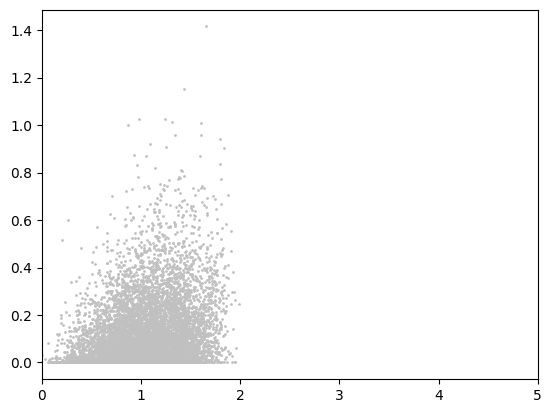

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0800,  E(|Y-Yhat|): 0.1963,  E(|Yhat-Yhat'|): 0.2325
[Epoch 100 (50%)] energy-loss: 0.0617,  E(|Y-Yhat|): 0.1235,  E(|Yhat-Yhat'|): 0.1235
[Epoch 200 (100%)] energy-loss: 0.0613,  E(|Y-Yhat|): 0.1252,  E(|Yhat-Yhat'|): 0.1278

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0647,  E(|Y-Yhat|): 0.1411,  E(|Yhat-Yhat'|): 0.1528

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2591, 1.5805])
Difference between true weight vector and learned weight vect

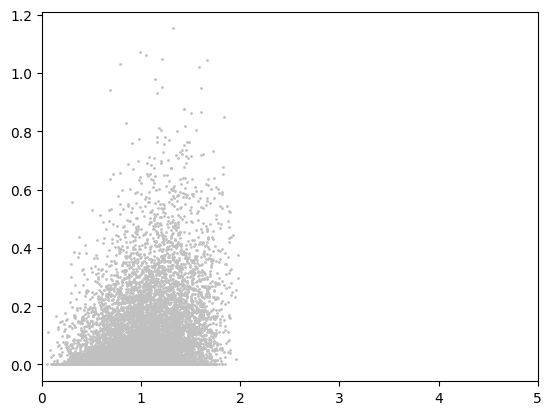

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0665,  E(|Y-Yhat|): 0.1339,  E(|Yhat-Yhat'|): 0.1348
[Epoch 100 (50%)] energy-loss: 0.0612,  E(|Y-Yhat|): 0.1294,  E(|Yhat-Yhat'|): 0.1363
[Epoch 200 (100%)] energy-loss: 0.0620,  E(|Y-Yhat|): 0.1198,  E(|Yhat-Yhat'|): 0.1156

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0613,  E(|Y-Yhat|): 0.1241,  E(|Yhat-Yhat'|): 0.1256

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2871, 1.5264])
Difference between true weight vector and learned weight vect

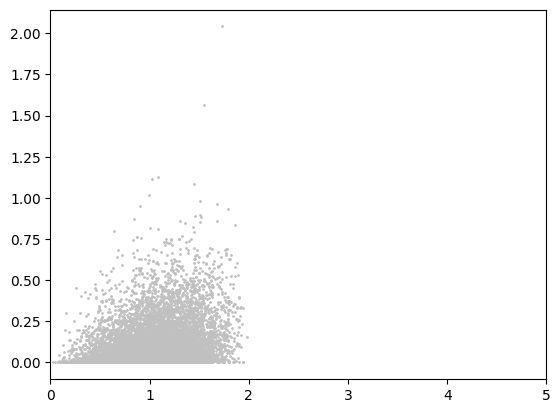

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0840,  E(|Y-Yhat|): 0.1180,  E(|Yhat-Yhat'|): 0.0679
[Epoch 100 (50%)] energy-loss: 0.0641,  E(|Y-Yhat|): 0.1278,  E(|Yhat-Yhat'|): 0.1275
[Epoch 200 (100%)] energy-loss: 0.0621,  E(|Y-Yhat|): 0.1209,  E(|Yhat-Yhat'|): 0.1176

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0615,  E(|Y-Yhat|): 0.1236,  E(|Yhat-Yhat'|): 0.1241

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3040, 1.5711])
Difference between true weight vector and learned weight vect

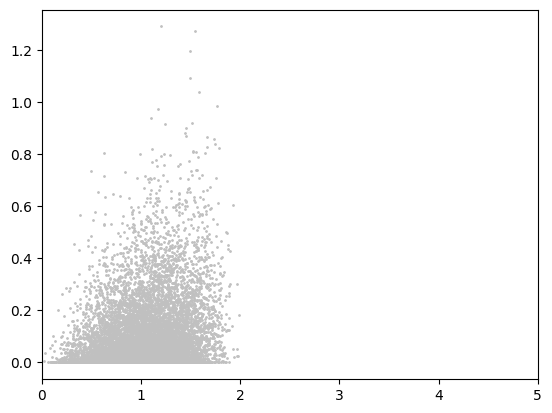

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0757,  E(|Y-Yhat|): 0.1310,  E(|Yhat-Yhat'|): 0.1106
[Epoch 100 (50%)] energy-loss: 0.0619,  E(|Y-Yhat|): 0.1227,  E(|Yhat-Yhat'|): 0.1217
[Epoch 200 (100%)] energy-loss: 0.0629,  E(|Y-Yhat|): 0.1238,  E(|Yhat-Yhat'|): 0.1220

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0618,  E(|Y-Yhat|): 0.1260,  E(|Yhat-Yhat'|): 0.1285

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3010, 1.5603])
Difference between true weight vector and learned weight vect

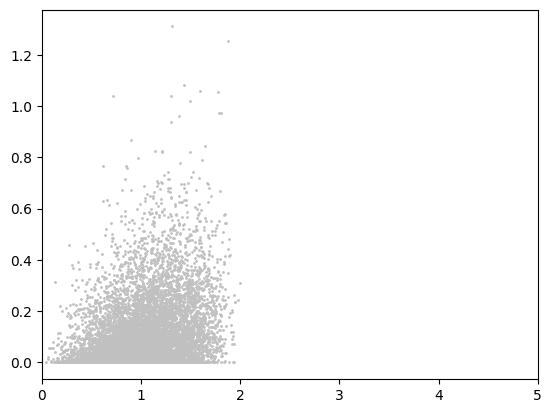

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1536,  E(|Y-Yhat|): 0.3198,  E(|Yhat-Yhat'|): 0.3324
[Epoch 100 (50%)] energy-loss: 0.0596,  E(|Y-Yhat|): 0.1222,  E(|Yhat-Yhat'|): 0.1251
[Epoch 200 (100%)] energy-loss: 0.0602,  E(|Y-Yhat|): 0.1191,  E(|Yhat-Yhat'|): 0.1178

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0596,  E(|Y-Yhat|): 0.1199,  E(|Yhat-Yhat'|): 0.1205

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3189, 1.5434])
Difference between true weight vector and learned weight vect

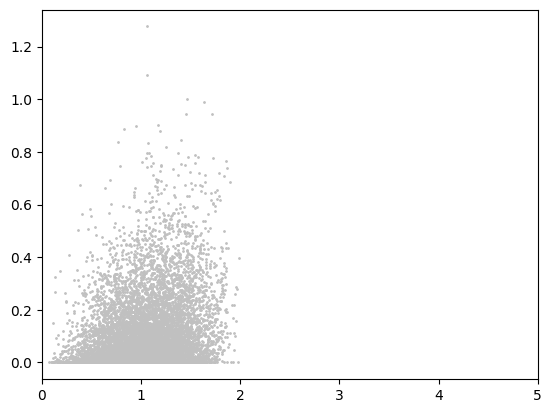

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1311,  E(|Y-Yhat|): 0.2728,  E(|Yhat-Yhat'|): 0.2835
[Epoch 100 (50%)] energy-loss: 0.0610,  E(|Y-Yhat|): 0.1267,  E(|Yhat-Yhat'|): 0.1313
[Epoch 200 (100%)] energy-loss: 0.0610,  E(|Y-Yhat|): 0.1213,  E(|Yhat-Yhat'|): 0.1205

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0605,  E(|Y-Yhat|): 0.1248,  E(|Yhat-Yhat'|): 0.1285

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2441, 1.5974])
Difference between true weight vector and learned weight vect

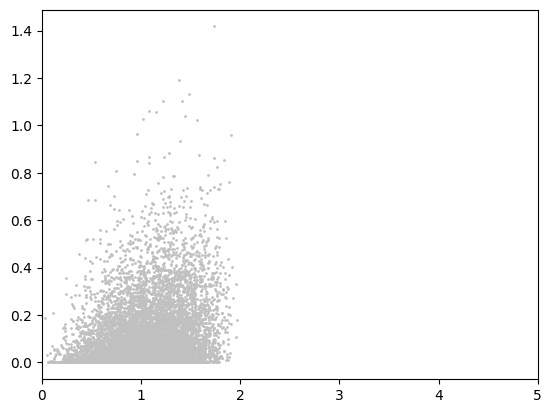

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1116,  E(|Y-Yhat|): 0.2179,  E(|Yhat-Yhat'|): 0.2125
[Epoch 100 (50%)] energy-loss: 0.0640,  E(|Y-Yhat|): 0.1315,  E(|Yhat-Yhat'|): 0.1351
[Epoch 200 (100%)] energy-loss: 0.0632,  E(|Y-Yhat|): 0.1282,  E(|Yhat-Yhat'|): 0.1299

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0638,  E(|Y-Yhat|): 0.1353,  E(|Yhat-Yhat'|): 0.1430

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3234, 1.4814])
Difference between true weight vector and learned weight vect

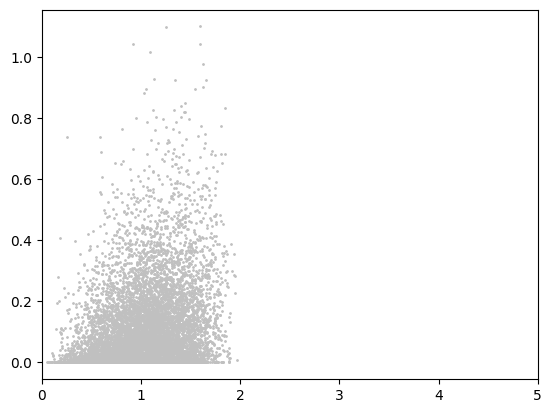

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1471,  E(|Y-Yhat|): 0.3053,  E(|Yhat-Yhat'|): 0.3164
[Epoch 100 (50%)] energy-loss: 0.0607,  E(|Y-Yhat|): 0.1231,  E(|Yhat-Yhat'|): 0.1247
[Epoch 200 (100%)] energy-loss: 0.0598,  E(|Y-Yhat|): 0.1218,  E(|Yhat-Yhat'|): 0.1241

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0607,  E(|Y-Yhat|): 0.1233,  E(|Yhat-Yhat'|): 0.1251

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.1942, 1.6007])
Difference between true weight vector and learned weight vect

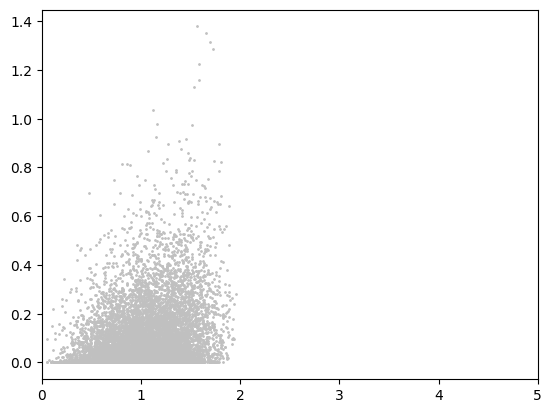

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0955,  E(|Y-Yhat|): 0.2273,  E(|Yhat-Yhat'|): 0.2637
[Epoch 100 (50%)] energy-loss: 0.0604,  E(|Y-Yhat|): 0.1215,  E(|Yhat-Yhat'|): 0.1222
[Epoch 200 (100%)] energy-loss: 0.0603,  E(|Y-Yhat|): 0.1222,  E(|Yhat-Yhat'|): 0.1239

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0614,  E(|Y-Yhat|): 0.1250,  E(|Yhat-Yhat'|): 0.1271

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.1568, 1.5944])
Difference between true weight vector and learned weight vect

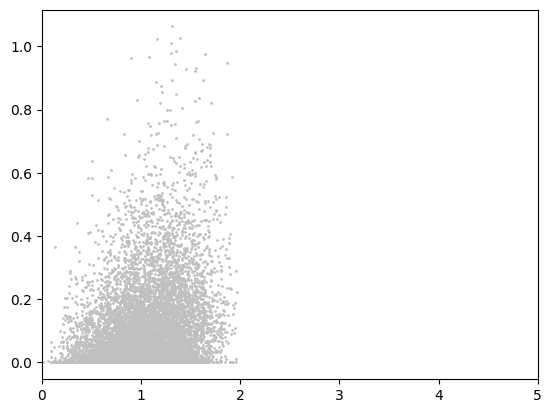

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0847,  E(|Y-Yhat|): 0.1174,  E(|Yhat-Yhat'|): 0.0654
[Epoch 100 (50%)] energy-loss: 0.0608,  E(|Y-Yhat|): 0.1248,  E(|Yhat-Yhat'|): 0.1280
[Epoch 200 (100%)] energy-loss: 0.0606,  E(|Y-Yhat|): 0.1241,  E(|Yhat-Yhat'|): 0.1270

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0609,  E(|Y-Yhat|): 0.1218,  E(|Yhat-Yhat'|): 0.1218

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3304, 1.6116])
Difference between true weight vector and learned weight vect

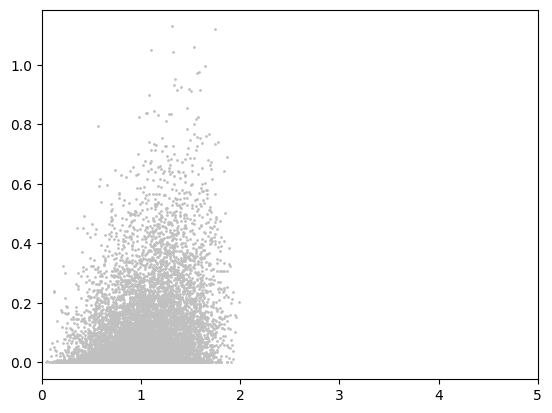

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0867,  E(|Y-Yhat|): 0.1174,  E(|Yhat-Yhat'|): 0.0614
[Epoch 100 (50%)] energy-loss: 0.0628,  E(|Y-Yhat|): 0.1212,  E(|Yhat-Yhat'|): 0.1168
[Epoch 200 (100%)] energy-loss: 0.0625,  E(|Y-Yhat|): 0.1281,  E(|Yhat-Yhat'|): 0.1312

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0633,  E(|Y-Yhat|): 0.1220,  E(|Yhat-Yhat'|): 0.1172

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.3198, 1.6069])
Difference between true weight vector and learned weight vect

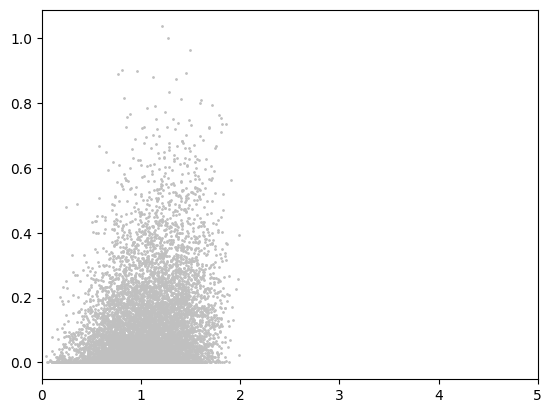

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0742,  E(|Y-Yhat|): 0.1278,  E(|Yhat-Yhat'|): 0.1073
[Epoch 100 (50%)] energy-loss: 0.0617,  E(|Y-Yhat|): 0.1231,  E(|Yhat-Yhat'|): 0.1228
[Epoch 200 (100%)] energy-loss: 0.0616,  E(|Y-Yhat|): 0.1232,  E(|Yhat-Yhat'|): 0.1232

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0604,  E(|Y-Yhat|): 0.1221,  E(|Yhat-Yhat'|): 0.1234

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2574, 1.5816])
Difference between true weight vector and learned weight vect

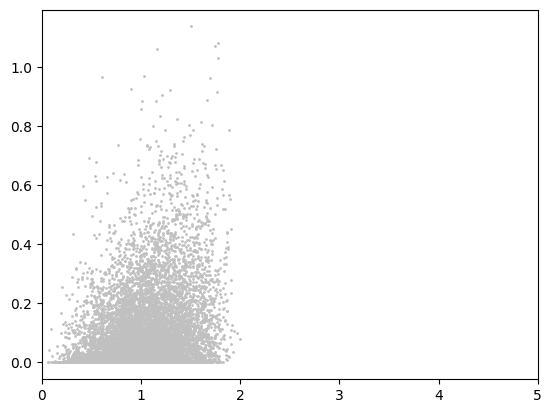

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1132,  E(|Y-Yhat|): 0.2635,  E(|Yhat-Yhat'|): 0.3005
[Epoch 100 (50%)] energy-loss: 0.0613,  E(|Y-Yhat|): 0.1273,  E(|Yhat-Yhat'|): 0.1321
[Epoch 200 (100%)] energy-loss: 0.0619,  E(|Y-Yhat|): 0.1247,  E(|Yhat-Yhat'|): 0.1256

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0616,  E(|Y-Yhat|): 0.1271,  E(|Yhat-Yhat'|): 0.1309

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2543, 1.5272])
Difference between true weight vector and learned weight vect

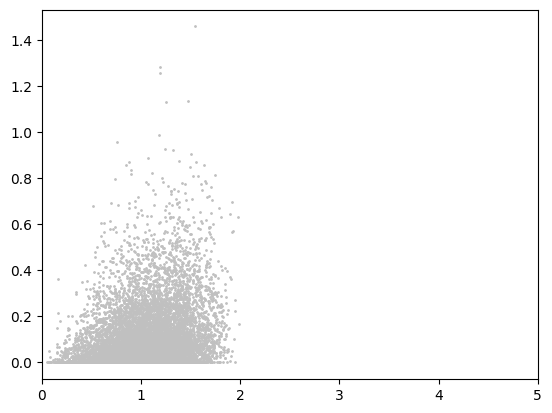

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0786,  E(|Y-Yhat|): 0.1312,  E(|Yhat-Yhat'|): 0.1053
[Epoch 100 (50%)] energy-loss: 0.0618,  E(|Y-Yhat|): 0.1207,  E(|Yhat-Yhat'|): 0.1176
[Epoch 200 (100%)] energy-loss: 0.0616,  E(|Y-Yhat|): 0.1282,  E(|Yhat-Yhat'|): 0.1331

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0618,  E(|Y-Yhat|): 0.1355,  E(|Yhat-Yhat'|): 0.1473

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2102, 1.5425])
Difference between true weight vector and learned weight vect

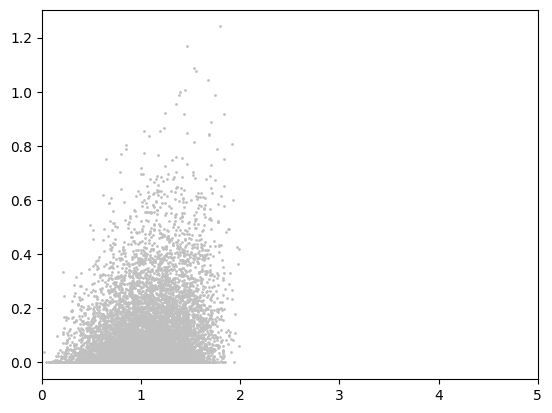

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0706,  E(|Y-Yhat|): 0.1442,  E(|Yhat-Yhat'|): 0.1473
[Epoch 100 (50%)] energy-loss: 0.0603,  E(|Y-Yhat|): 0.1216,  E(|Yhat-Yhat'|): 0.1226
[Epoch 200 (100%)] energy-loss: 0.0606,  E(|Y-Yhat|): 0.1237,  E(|Yhat-Yhat'|): 0.1261

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0604,  E(|Y-Yhat|): 0.1213,  E(|Yhat-Yhat'|): 0.1219

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2310, 1.4827])
Difference between true weight vector and learned weight vect

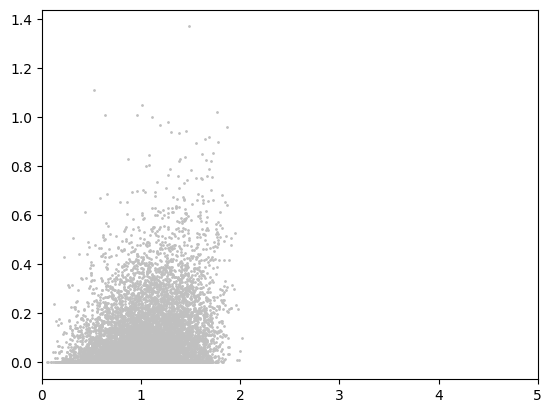

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.1294,  E(|Y-Yhat|): 0.2907,  E(|Yhat-Yhat'|): 0.3227
[Epoch 100 (50%)] energy-loss: 0.0614,  E(|Y-Yhat|): 0.1249,  E(|Yhat-Yhat'|): 0.1270
[Epoch 200 (100%)] energy-loss: 0.0603,  E(|Y-Yhat|): 0.1265,  E(|Yhat-Yhat'|): 0.1325

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0615,  E(|Y-Yhat|): 0.1291,  E(|Yhat-Yhat'|): 0.1353

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.2222, 1.5810])
Difference between true weight vector and learned weight vect

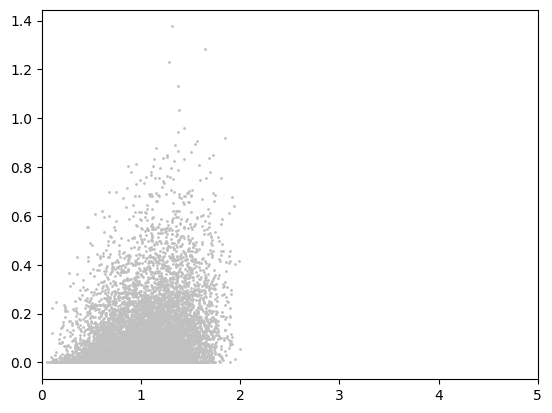

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0692,  E(|Y-Yhat|): 0.1499,  E(|Yhat-Yhat'|): 0.1614
[Epoch 100 (50%)] energy-loss: 0.0637,  E(|Y-Yhat|): 0.1245,  E(|Yhat-Yhat'|): 0.1217
[Epoch 200 (100%)] energy-loss: 0.0632,  E(|Y-Yhat|): 0.1260,  E(|Yhat-Yhat'|): 0.1255

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0628,  E(|Y-Yhat|): 0.1252,  E(|Yhat-Yhat'|): 0.1246

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.1903, 1.5653])
Difference between true weight vector and learned weight vect

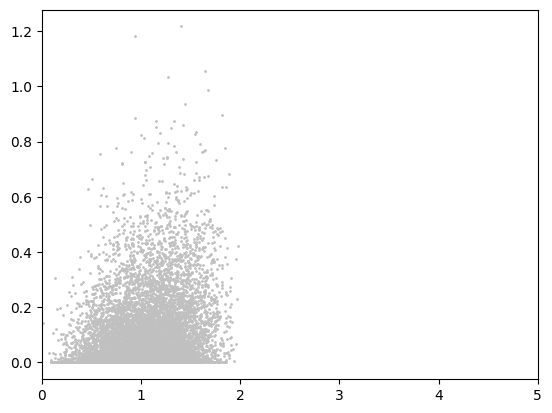

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0771,  E(|Y-Yhat|): 0.1875,  E(|Yhat-Yhat'|): 0.2209
[Epoch 100 (50%)] energy-loss: 0.0605,  E(|Y-Yhat|): 0.1267,  E(|Yhat-Yhat'|): 0.1322
[Epoch 200 (100%)] energy-loss: 0.0598,  E(|Y-Yhat|): 0.1220,  E(|Yhat-Yhat'|): 0.1244

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0599,  E(|Y-Yhat|): 0.1243,  E(|Yhat-Yhat'|): 0.1288

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.1592, 1.4699])
Difference between true weight vector and learned weight vect

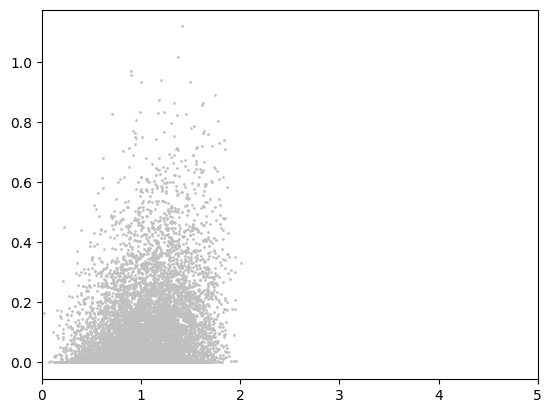

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0723,  E(|Y-Yhat|): 0.1301,  E(|Yhat-Yhat'|): 0.1155
[Epoch 100 (50%)] energy-loss: 0.0619,  E(|Y-Yhat|): 0.1248,  E(|Yhat-Yhat'|): 0.1258
[Epoch 200 (100%)] energy-loss: 0.0627,  E(|Y-Yhat|): 0.1310,  E(|Yhat-Yhat'|): 0.1367

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0615,  E(|Y-Yhat|): 0.1309,  E(|Yhat-Yhat'|): 0.1388

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.1685, 1.4436])
Difference between true weight vector and learned weight vect

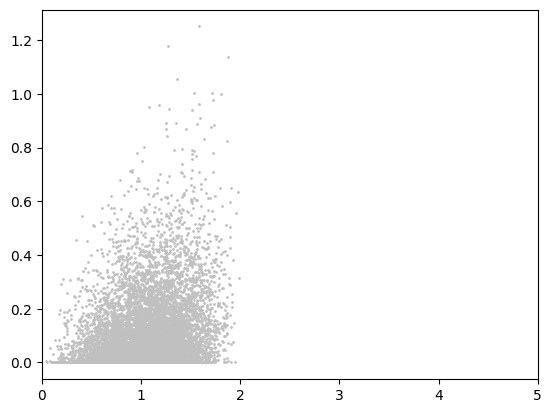

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.0827,  E(|Y-Yhat|): 0.1159,  E(|Yhat-Yhat'|): 0.0664
[Epoch 100 (50%)] energy-loss: 0.0605,  E(|Y-Yhat|): 0.1209,  E(|Yhat-Yhat'|): 0.1208
[Epoch 200 (100%)] energy-loss: 0.0596,  E(|Y-Yhat|): 0.1259,  E(|Yhat-Yhat'|): 0.1324

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.0603,  E(|Y-Yhat|): 0.1255,  E(|Yhat-Yhat'|): 0.1304

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
nonzero weight values: tensor([1.0000, 1.0642, 1.5912])
Difference between true weight vector and learned weight vect

In [ ]:
N_sim = 20
x_min = -0.55
x_max = 1.64
x_lower = 0
x_upper = 0.55
true_function = "square" # ["square", "softplus", "cubic", "log"]
noise_dist = "gaussian"
#noise_dist = "uniform"
noise_correlation = 0
num_epochs = 200
n_train=10000
num_points = 1000
noise_std = 0.1
lr = 0.005
batch_size=5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results1 = run_dsr_simulations(
    N_sim=N_sim, x_min=x_min, x_max=x_max,
    x_lower=x_lower,x_upper=x_upper,
    true_function=true_function,
    n_train=n_train,
    noise_dist=noise_dist,
    noise_corr=noise_correlation,
    num_epochs=num_epochs,
    num_points=num_points,
    noise_std = noise_std,
    batch_size = batch_size,
    device=device,lr=lr
)

In [ ]:
np.savez("~/simresults2_DSR_square1.npz", results_square1=results1)

## Run L2 simulations

In [ ]:
def run_compare_simulations(
    N_sim,
    x_min, x_max, num_points,
    n_train, x_lower, x_upper, noise_std,
    lr, num_epochs, batch_size,
    true_function, noise_dist, noise_corr, device="cpu"
):
    """
    Run multiple L2 simulations and store results.
    """
    # Arrays to store results
    predicted_means = []
    L2_errors = []
    weight_estimates = []
    predicted_gs = []

    # Set the seed
    torch_seed = 42
    torch.manual_seed(torch_seed)
    np.random.seed(torch_seed)


    ## truth for comparison
    x_eval, y_eval_med, y_eval_mean = preanm_simulator_64d(true_function=true_function, n=num_points,
                                                           x_lower=x_min, x_upper=x_max, noise_std=noise_std, noise_dist=noise_dist,
                                                           train=False, noise_corr=noise_corr, device=device)

    y_true_mean = y_eval_mean.cpu().numpy()


    a1 = a_true
    x_test_1d = x_eval @ a1.unsqueeze(1)


    # Run simulations
    for sim in range(N_sim):
        print(f"\nRunning simulation {sim + 1}/{N_sim}")

        torch_seed = sim
        torch.manual_seed(torch_seed)
        np.random.seed(torch_seed)


        # Generate training data
        x_train, y_train = preanm_simulator_64d(
            true_function=true_function,
            n=n_train, x_lower=x_lower, x_upper=x_upper,
            noise_std=noise_std, noise_dist=noise_dist,
            train=True, noise_corr=noise_corr, device=device
        )

        model = MyNet(
        in_dim=64,
        out_dim=1,
        num_layer=3,
        hidden_dim=100,
        add_bn=True,
        sigmoid=False
        )

        train_model(
        model=model,
        X_train=x_train,
        y_train=y_train,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        device=device
        )

        y_pred_mean = predict_model(model, x_eval, device)  ## using beta_hat
        g_pred = predict_g(model, x_eval, device)  ## using true beta

        mse_loss = nn.MSELoss()
        L2_error = mse_loss(y_pred_mean, y_eval_mean)

        # Retrieve the weight vector
        weight_vector = model.get_weight_vector()
        learned_weight_vector_tensor = torch.from_numpy(weight_vector)
        print("nonzero weight values:",learned_weight_vector_tensor[[0,30,58]])
        diff = learned_weight_vector_tensor - a1
        disc_diff = torch.norm(diff, p=2)
        disc_diff = np.float32(disc_diff.item())
        print(f"Difference between true weight vector and learned weight vector: {disc_diff:.8f}")

        # Store results
        predicted_means.append(y_pred_mean)
        L2_errors.append(L2_error)
        weight_estimates.append(weight_vector)
        predicted_gs.append(g_pred)

    # Convert lists to NumPy arrays
    predicted_means = np.array(predicted_means)
    L2_errors = np.array(L2_errors)
    weight_estimates = np.array(weight_estimates)
    predicted_gs = np.array(predicted_gs)

    x_train_example = x_train @ a1.unsqueeze(1)
    y_train_example = y_train

    # Return results in a dictionary
    results = {
        'predicted_means': predicted_means,
        'predicted_funs': predicted_gs,
        'L2_errors': L2_errors,
        'weight_estimates': weight_estimates,
        # Include for plotting
        'x_train': x_train_example,
        'y_train': y_train_example,
        'x_test': x_test_1d,
        'y_true_mean': y_true_mean
    }

    return results


Running simulation 1/20


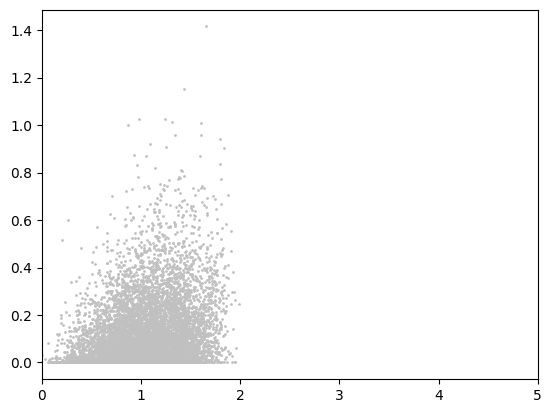

Epoch 100/200, Loss: 0.019597
Epoch 200/200, Loss: 0.017743
nonzero weight values: tensor([1.0000, 2.4506, 2.8314])
Difference between true weight vector and learned weight vector: 2.13008213

Running simulation 2/20


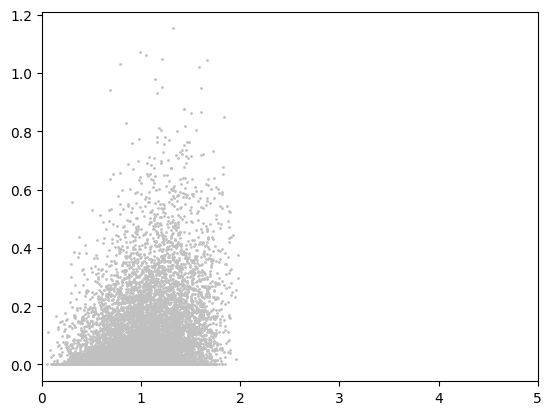

Epoch 100/200, Loss: 0.017894
Epoch 200/200, Loss: 0.017052
nonzero weight values: tensor([1.0000, 3.2434, 3.5703])
Difference between true weight vector and learned weight vector: 3.26984787

Running simulation 3/20


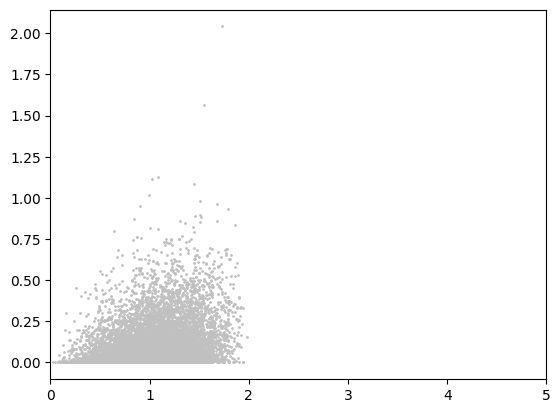

Epoch 100/200, Loss: 0.018854
Epoch 200/200, Loss: 0.018174
nonzero weight values: tensor([1.0000, 3.8280, 4.4287])
Difference between true weight vector and learned weight vector: 4.18860340

Running simulation 4/20


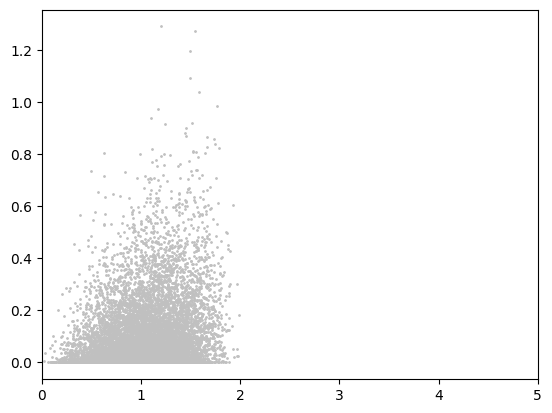

Epoch 100/200, Loss: 0.018572
Epoch 200/200, Loss: 0.017742
nonzero weight values: tensor([1.0000, 4.5086, 5.2198])
Difference between true weight vector and learned weight vector: 5.31790781

Running simulation 5/20


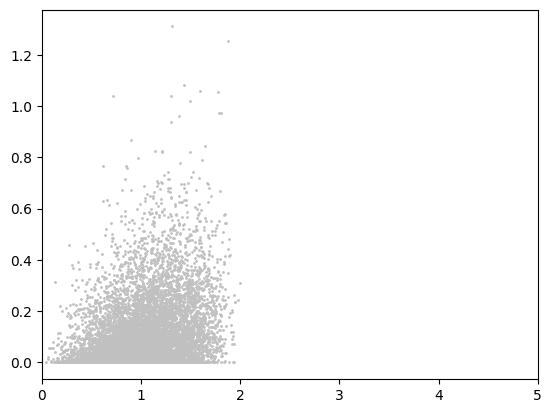

Epoch 100/200, Loss: 0.017738
Epoch 200/200, Loss: 0.016784
nonzero weight values: tensor([1.0000, 5.2257, 5.7625])
Difference between true weight vector and learned weight vector: 6.22228003

Running simulation 6/20


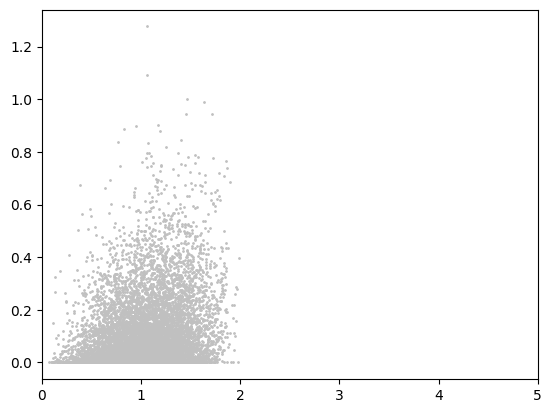

Epoch 100/200, Loss: 0.018642
Epoch 200/200, Loss: 0.017521
nonzero weight values: tensor([1.0000, 5.4532, 6.5956])
Difference between true weight vector and learned weight vector: 7.02725077

Running simulation 7/20


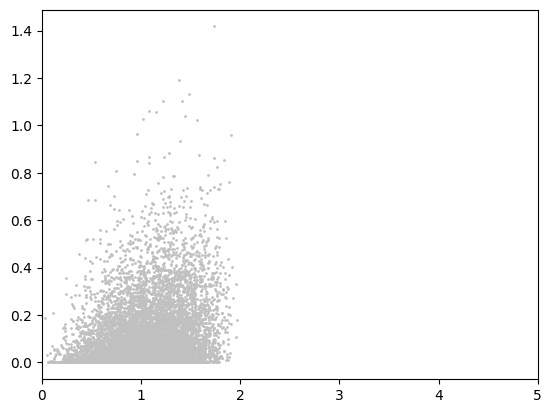

Epoch 100/200, Loss: 0.019236
Epoch 200/200, Loss: 0.018272
nonzero weight values: tensor([1.0000, 6.1639, 6.7304])
Difference between true weight vector and learned weight vector: 7.50533438

Running simulation 8/20


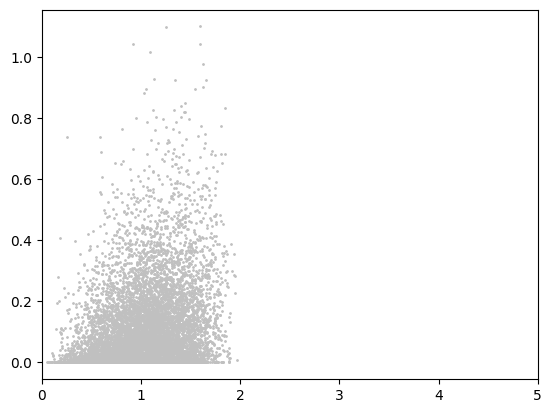

Epoch 100/200, Loss: 0.018288
Epoch 200/200, Loss: 0.017408
nonzero weight values: tensor([1.0000, 6.4414, 7.8243])
Difference between true weight vector and learned weight vector: 8.59374142

Running simulation 9/20


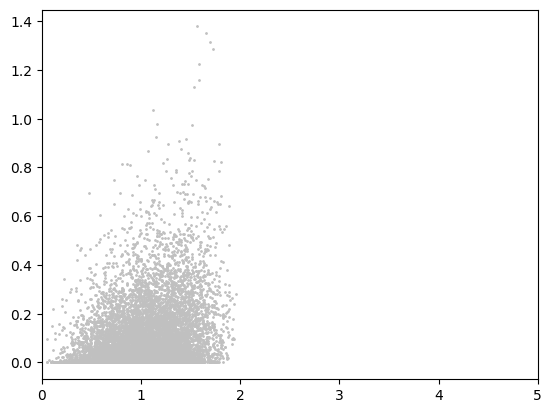

Epoch 100/200, Loss: 0.018980
Epoch 200/200, Loss: 0.017930
nonzero weight values: tensor([1.0000, 6.8335, 8.5544])
Difference between true weight vector and learned weight vector: 9.28208733

Running simulation 10/20


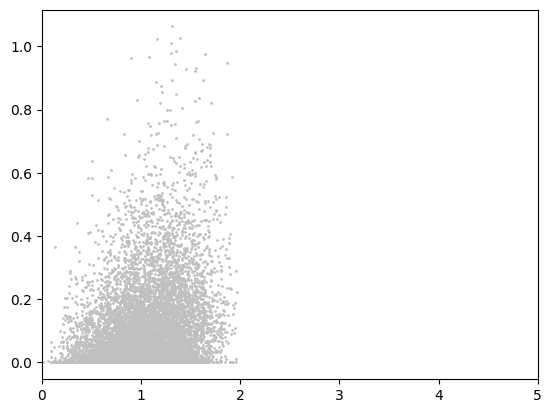

Epoch 100/200, Loss: 0.017688
Epoch 200/200, Loss: 0.017089
nonzero weight values: tensor([1.0000, 7.3846, 8.9486])
Difference between true weight vector and learned weight vector: 10.03350544

Running simulation 11/20


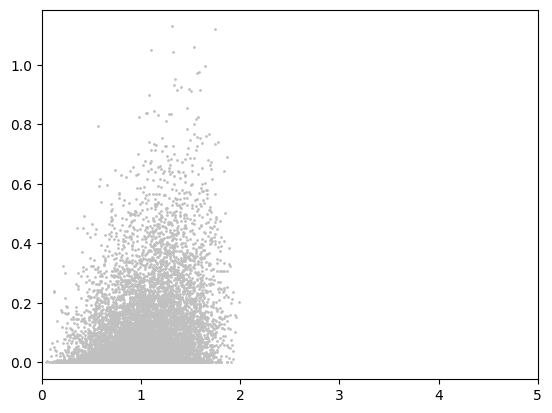

Epoch 100/200, Loss: 0.018781
Epoch 200/200, Loss: 0.018002
nonzero weight values: tensor([1.0000, 7.9972, 9.4022])
Difference between true weight vector and learned weight vector: 10.72606373

Running simulation 12/20


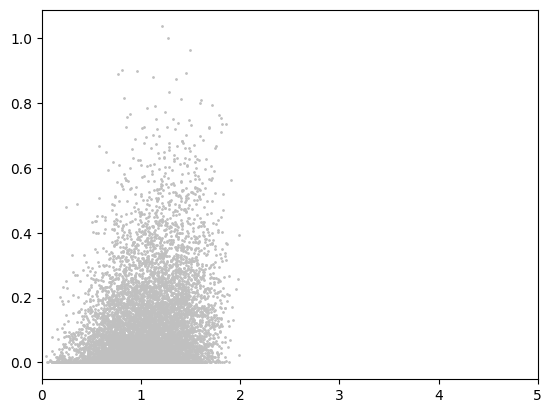

Epoch 100/200, Loss: 0.017610
Epoch 200/200, Loss: 0.016647
nonzero weight values: tensor([ 1.0000,  8.1771, 10.1015])
Difference between true weight vector and learned weight vector: 11.37986469

Running simulation 13/20


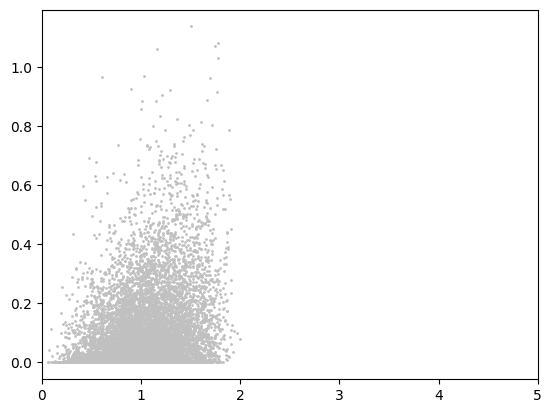

Epoch 100/200, Loss: 0.019084
Epoch 200/200, Loss: 0.018047
nonzero weight values: tensor([ 1.0000,  8.7851, 10.1714])
Difference between true weight vector and learned weight vector: 11.81666946

Running simulation 14/20


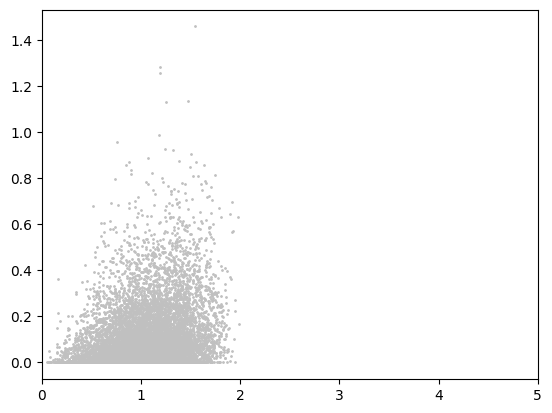

Epoch 100/200, Loss: 0.018312
Epoch 200/200, Loss: 0.017751
nonzero weight values: tensor([ 1.0000,  8.9396, 10.7863])
Difference between true weight vector and learned weight vector: 12.41366196

Running simulation 15/20


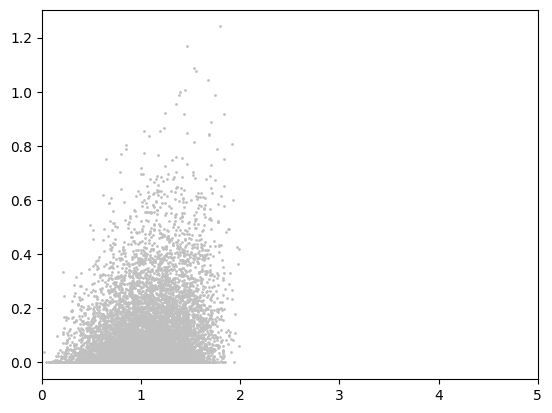

Epoch 100/200, Loss: 0.017970
Epoch 200/200, Loss: 0.017198
nonzero weight values: tensor([ 1.0000,  9.4352, 11.1978])
Difference between true weight vector and learned weight vector: 13.06907177

Running simulation 16/20


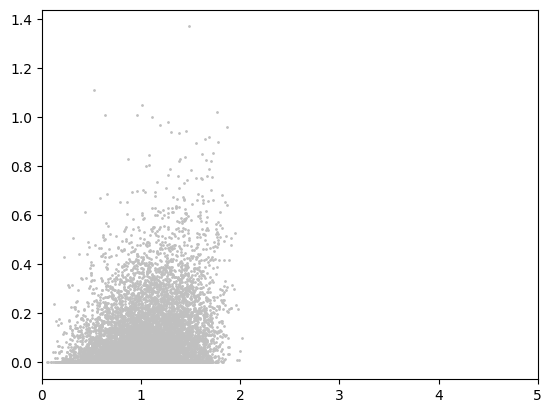

Epoch 100/200, Loss: 0.018601
Epoch 200/200, Loss: 0.018056
nonzero weight values: tensor([ 1.0000, 10.0444, 11.7638])
Difference between true weight vector and learned weight vector: 13.88496304

Running simulation 17/20


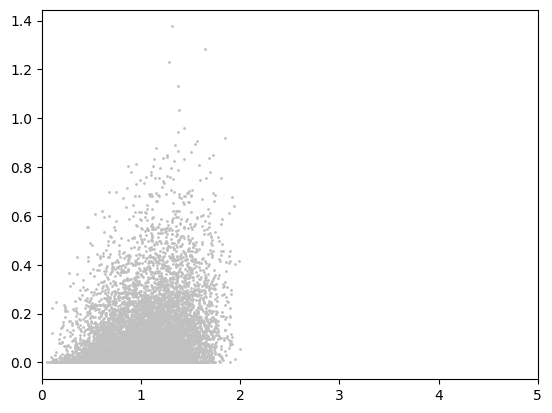

Epoch 100/200, Loss: 0.019473
Epoch 200/200, Loss: 0.018543
nonzero weight values: tensor([ 1.0000, 10.3792, 12.2061])
Difference between true weight vector and learned weight vector: 14.42027664

Running simulation 18/20


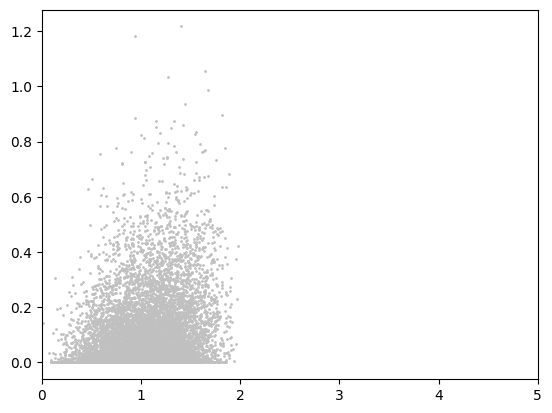

Epoch 100/200, Loss: 0.018201
Epoch 200/200, Loss: 0.017264
nonzero weight values: tensor([ 1.0000, 10.9994, 12.4083])
Difference between true weight vector and learned weight vector: 14.92789555

Running simulation 19/20


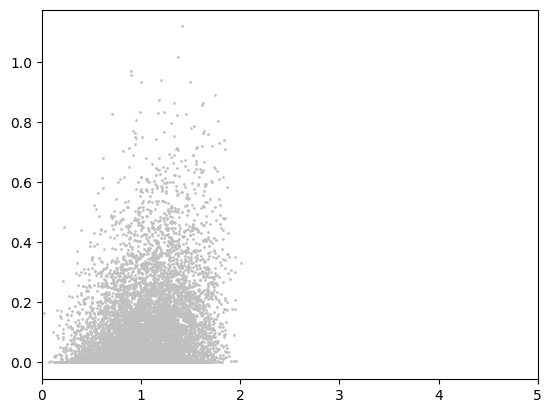

Epoch 100/200, Loss: 0.018263
Epoch 200/200, Loss: 0.017278
nonzero weight values: tensor([ 1.0000, 11.3541, 12.9084])
Difference between true weight vector and learned weight vector: 15.57853794

Running simulation 20/20


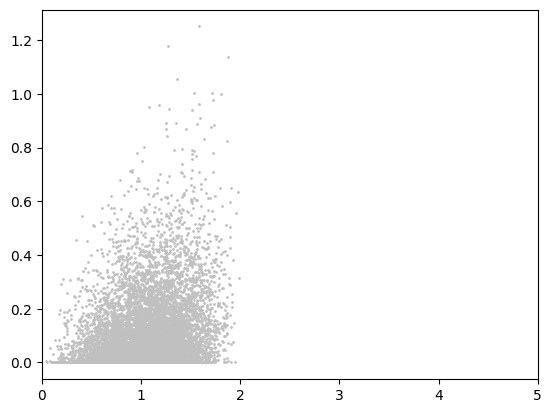

Epoch 100/200, Loss: 0.017603
Epoch 200/200, Loss: 0.016940
nonzero weight values: tensor([ 1.0000, 11.0594, 13.7615])
Difference between true weight vector and learned weight vector: 16.03108406


In [ ]:
N_sim = 20
x_min = -0.55
x_max = 1.64
x_lower = 0
x_upper = 0.55
true_function = "square"
noise_dist = "gaussian"
#noise_dist = "uniform"
noise_correlation = 0
num_epochs = 200
n_train=10000
num_points = 1000
noise_std = 0.1
lr = 0.005
batch_size=5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results1_L2 = run_compare_simulations(
    N_sim=N_sim, x_min=x_min, x_max=x_max,
    x_lower=x_lower,x_upper=x_upper,
    true_function=true_function,
    n_train=n_train,
    noise_dist=noise_dist,
    noise_corr=noise_correlation,
    num_epochs=num_epochs,
    num_points=num_points,
    noise_std = noise_std,
    batch_size = batch_size,
    device=device,lr=lr
)

In [ ]:
np.savez("/content/drive/MyDrive/engression_code/simresults2_regression_square1.npz", results_square1=results1_L2)